In [2]:
import torch
import torch.nn as nn 


import os 
import matplotlib.pyplot as plt

FILE_PATH = os.getcwd()
print(FILE_PATH)

/Users/mohitdulani/Desktop/personal/sencillo-robotics


In [26]:
# This is a ViT model 
from datasets import load_dataset
from PIL import Image  # force Pillow import


# lets take a small image 
# ds = load_dataset("itsmohit/stl10_5percent", split='test',  cache_dir=FILE_PATH, )
ds = load_dataset('mnist', split='train[:100]', cache_dir = FILE_PATH)
print(ds)

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset({
    features: ['image', 'label'],
    num_rows: 100
})


In [37]:
# Print the first element of the dataset to inspect its structure
print(ds[0])

# Correctly open the image using PIL's Image module
image = ds[0].get('image')

# Display the image to verify it was loaded correctly
# image.show()

{'image': <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28 at 0x16E366FD0>, 'label': 5}


Get a car image and use it 

In [76]:
#load the car image 
from PIL import Image
image_path = 'assets/images/car_img.jpg'
image = Image.open(image_path).convert("RGB")  # ensure 3 channels

image.show()

In [77]:
# visualise this image using mtl 
import numpy as np
import torchvision.transforms as transforms

# Define transformation: resize and convert to tensor
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()  # Converts to (C, H, W) and normalizes to [0, 1]
])

# Apply transform
img_tensor = transform(image)  # shape: (3, 224, 224)
print('image tensor shape is :', img_tensor.shape)

# img_array = np.array(img_tensor, )  # shape: (128, 128, 3) for RGB
img_array = img_tensor.permute(1, 2, 0).numpy()
img_array = (img_array * 255).astype(np.uint8)
print('image array size is : ' , img_array.shape)

# Patch size
patch_size = 16

# Compute number of patches along height and width
num_patches_h = img_array.shape[0] // patch_size
num_patches_w = img_array.shape[1] // patch_size

# Split into patches
patches = []
for i in range(num_patches_h):
    for j in range(num_patches_w):
        patch = img_array[
            i*patch_size:(i+1)*patch_size,
            j*patch_size:(j+1)*patch_size
        ]
        patches.append(patch)

print(patches[0].shape)
# Convert patches back to PIL images if needed
# patches_pil = [Image.fromarray(p) for p in patches]

n_patches = len(patches)
print(f"Total patches: {len(patches)}")  # 128x128 / 14x14 = 64 patches
print(f"Patch shape: {patches[0].shape}")  # (14, 14, 3)

image tensor shape is : torch.Size([3, 224, 224])
image array size is :  (224, 224, 3)
(16, 16, 3)
Total patches: 196
Patch shape: (16, 16, 3)


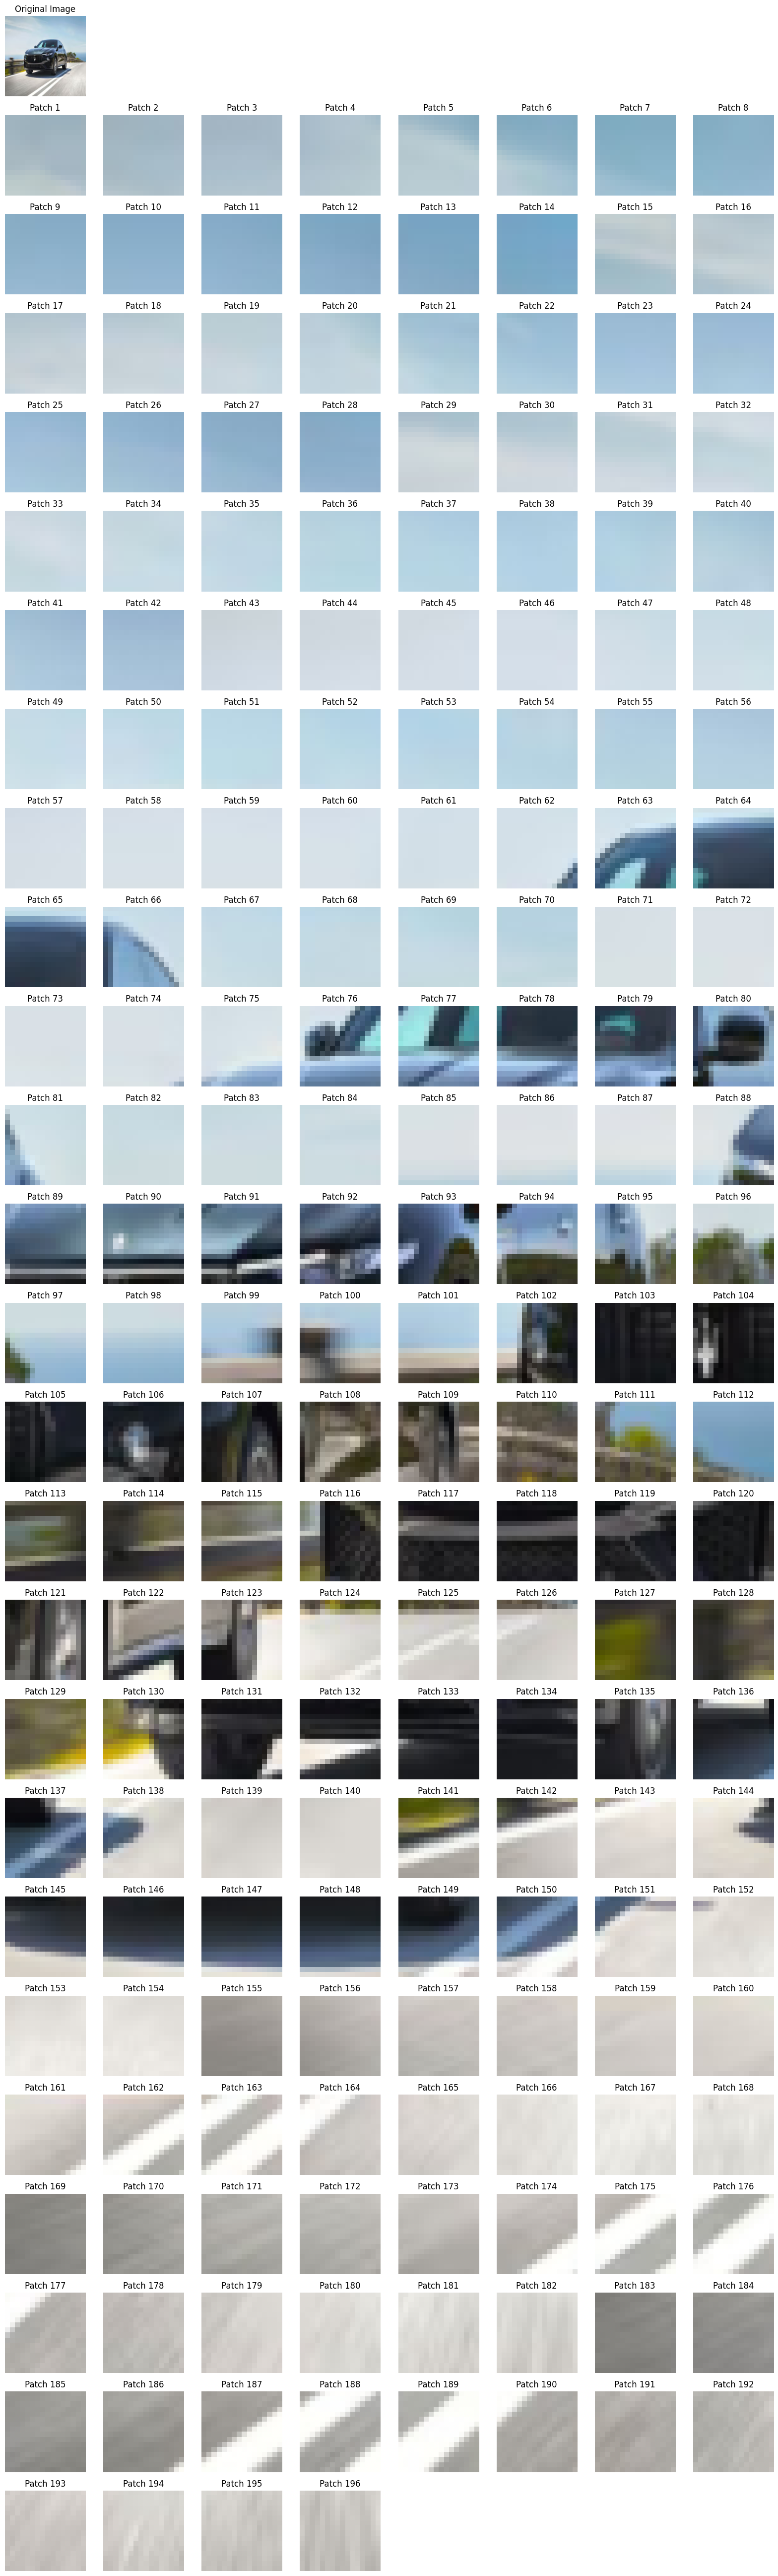

In [78]:

from math import ceil
# Parameteras for plotting
max_per_row = 8
num_patches = len(patches)
num_rows = ceil(num_patches / max_per_row)

# Create figure with original on top + patch rows
fig, axes = plt.subplots(num_rows + 1, max_per_row, figsize=(max_per_row*2, (num_rows+1)*2))

# Plot original image on top row, spanning all columns
for ax in axes[0]:
    ax.axis('off')
axes[0,0].imshow(img_array)
axes[0,0].set_title("Original Image")
for ax in axes[0,1:]:
    ax.set_visible(False)

# Plot patches
for idx, patch in enumerate(patches):
    row = (idx // max_per_row) + 1  # +1 to skip top row
    col = idx % max_per_row
    axes[row, col].imshow(patch)
    axes[row, col].set_title(f"Patch {idx+1}")
    axes[row, col].axis('off')

# Hide any empty axes
for i in range(num_patches, num_rows*max_per_row):
    row = (i // max_per_row) + 1
    col = i % max_per_row
    axes[row, col].set_visible(False)

plt.tight_layout()
plt.show()

#### The patches are divided and shown now we need to tokenize these patches
 

H x W x C => 28 x 28 x 1 

P = 7

No of patches = H*W / Pˆ2 => 28 x 28 / 7 x 7 => 4 x 4 -> 16 patches in total

So flatten out the 28 x 28 x 1 to (16 x 49)

--- 
H x W x C => 224 x 224 x 3 

P = 16

No of patches = H*W / Pˆ2 => 14 x 14 -> 196 patches in total

So flatten out the 224 x 224 x 3 to (196 x 768)



In [81]:
print("patches are : ", len(patches) , patches[0].shape)
# Flatten the patch to P x P x C 

flattened_image = []
for patch in patches:
    # flatten it out 
    flattened_patch = []
    if len(patch.shape) > 2: 
        for row in range(0,patch.shape[0]):
            for col in range(0 , patch.shape[1]):
                for chn in range(0, patch.shape[2]):
                    flattened_patch.append(patch[row][col][chn])

    else:
        for row in range(0,patch.shape[0]):
            for col in range(0 , patch.shape[1]):
                flattened_patch.append(patch[row][col])

    flattened_patch = torch.from_numpy(np.array(flattened_patch))
    flattened_image.append(flattened_patch)

flattened_image = torch.stack(flattened_image)

if flattened_image.shape[-1] == 1:
    flattened_image = flattened_image.squeeze(dim = -1)

print(flattened_image.shape)

patches are :  196 (16, 16, 3)
torch.Size([196, 768])


## Preprocessing before passing the input 

> add the position embedding and the [CLS] token as well 
> 
> 

![ViT model](assets/images/vit.png)

In [89]:
# This is what we is in the original paper !! https://arxiv.org/pdf/2010.11929

from torchvision.models import vit_b_16

class VITModel(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__()
        patch = kwargs.get('patch')
        dim = kwargs.get('dim')
        max_input_tokens = kwargs.get('max_input_tokens') # this is not required ( always the images will be of fixed size )
        
        self.dim = dim 
        # N x D 
        self.lin_proj = nn.Linear(patch, dim)
        self.position_embedding = nn.Embedding(max_input_tokens, dim) # somethign that we need to limit based on the input tokens 
        self.cls_embed = nn.Parameter(data = torch.randn(size = (1, dim)))
        
        self.model_arch = vit_b_16()


    def forward(self, x, patches):
        position_vector = torch.arange(start = 1 , end = patches+1, step=1, dtype = torch.int64)
        patch_position_embedding = self.lin_proj(x) + self.position_embedding(position_vector) #element wise addition 

        # prepend with the cls token 
        cls_token_embed = self.cls_embed + self.position_embedding(torch.tensor([0])) # prepend at 0th index 

        cls_token_embed = self.cls_embed.unsqueeze(0)  # [1, 1, 768]

        print('cls token shape', cls_token_embed.shape)
        print('patch position ', patch_position_embedding.shape)

        input_x = torch.cat([cls_token_embed, patch_position_embedding], dim=1)

        assert input_x.shape[-1] == self.dim , 'Its equal to the hidden-dimension as mentioned'

        x = self.model_arch.encoder(input_x)
        x = self.model_arch.heads(x)[:, 0, :]

        return x

In [90]:
x = flattened_image.unsqueeze(0).float()
print(x.dtype, x.shape)
output_vector = VITModel(patch = x.shape[-1], dim = 768 , max_input_tokens = 197).forward(x, patches = x.shape[1])
print(output_vector.shape)
pred_class_idx = torch.argmax(output_vector, dim=1)
print(pred_class_idx)

torch.float32 torch.Size([1, 196, 768])
cls token shape torch.Size([1, 1, 768])
patch position  torch.Size([1, 196, 768])
torch.Size([1, 1000])
tensor([0])


In [ ]:
# here we can see we are using a convolutional 2d layer for patch embedding this is an follow up from the linear layers that original authors suggested  ( this is done for better memory access patterns , training speed and removes 2 step process )


VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

## Train the above ViT model and then only we will know whether its working fine or not !! or use a pretrained one  

## To visualise at end 

> The next most probable token in the image space
> Comparing this model's feature extraction to the one we get from the resnet / CNN models   
> Comparing the inference time and expanding the scope of paper 
> 
